## Implementation of Isolation Tree on NumPy

In this notebook, we aim to present a step-by-step working model of Isolation Tree. Isolation trees are building blocks of isolation forest, an ensmeble of isolation trees used for anomaly detection. 

[Isolation forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf) aims to find an anomaly in a dataset by taking two strong assumptions about them:
1. anomalies tend to behave like outliers in a distribution
2. the frequency of their occurance is a rare event 

So, specifically for the task of anomaly detection we would aim to extract features that would represent an anomalous event either as a rare event or as an outlier of a distribution.


In this notebook, we would use a small sample data from [Kaggle's Credit Card Fraud Analytics](https://www.kaggle.com/mlg-ulb/creditcardfraud) challenge. From the visualization we could tell the presence of an obvious anomaly and we would verify our findings with the results of average outputs of isolation trees. 

# Introduction about Isolation Trees



Isolation Forest explicitly identifies anomalies instead of profiling normal data points. Isolation Forest is built on the basis of isolation tree. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature.

In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). That is why by using such random partitioning they should be identified closer to the root of the tree (shorter average path length, i.e., the number of edges an observation must pass in the tree going from the root to the terminal node), with fewer splits necessary.



# importing libraries


In [2]:
import os 
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000, 'display.max_columns', 1000)
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.chdir("G://data science")

In [4]:
X=pd.read_excel("sdf.xlsx")

In [5]:
X

,V1,V2,V3,V4,V5
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321
1,1.191857,0.266151,0.166480,0.448154,0.060018
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309
4,-1.158233,0.877737,1.548718,0.403034,-0.407193
5,-0.425966,0.960523,1.141109,-0.168252,0.420987
6,1.229658,0.141004,0.045371,1.202613,0.191881
7,-0.644269,1.417964,1.074380,-0.492199,0.948934
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599
9,-0.338262,1.119593,1.044367,-0.222187,0.499361


In the visualization below, we can see the presence of an outlier in the histogram of V1, V2 and V5 and also in their respective pairplots with other variables. The datapoint would corrospond to X[18]. We should have the lowest anomaly score for X[18]. 

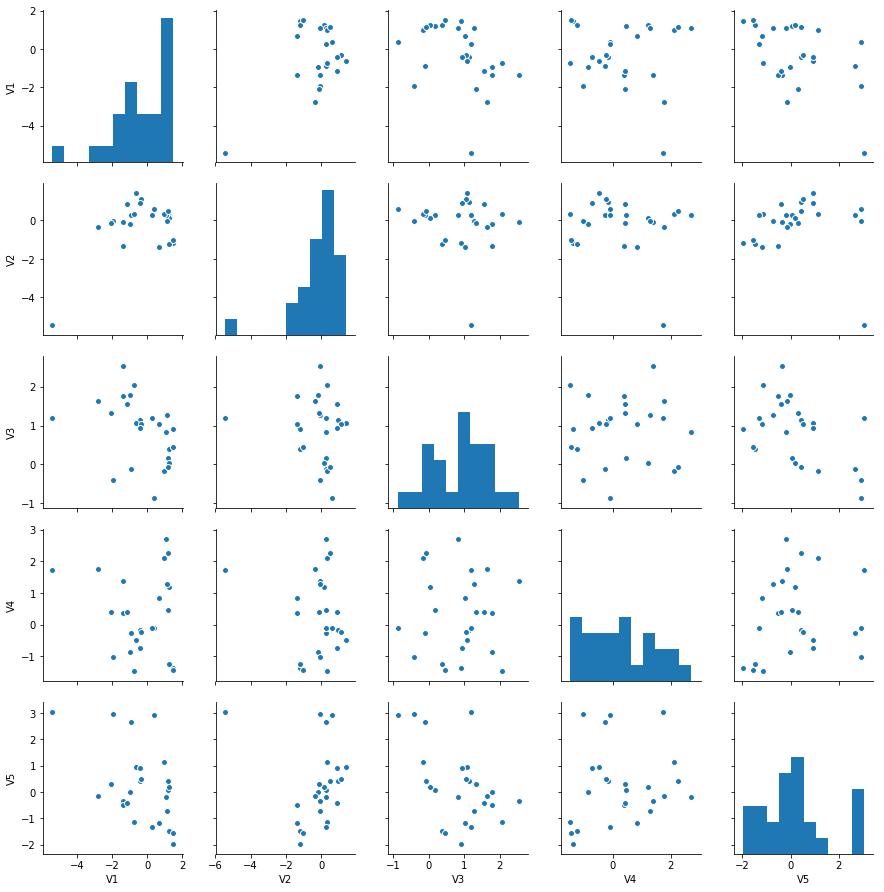

In [6]:
sns.pairplot(X)


In [7]:
X.describe()

,V1,V2,V3,V4,V5
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,-0.319467,-0.154856,0.872552,0.287324,0.211133
std,1.610059,1.324016,0.820556,1.227123,1.419190
min,-5.401258,-5.450148,-0.874300,-1.468643,-1.971383
25%,-1.110243,-0.292135,0.220843,-0.668464,-0.677797
50%,-0.382114,0.203577,1.036794,0.143589,0.024854
75%,1.094755,0.462961,1.308348,1.267472,0.811599
max,1.492936,1.417964,2.536347,2.712520,3.049106


Now, we would define classes and their respective constructors for defining external and internal nodes of a tree. We expect that the anomalous point would get inside the external node in less splits than a point near the mean of the distribution

In [8]:
class ExNode:
    def __init__(self,size):
        self.size=size
        
class InNode:
    def __init__(self,left,right,splitAtt,splitVal):
        self.left=left
        self.right=right
        self.splitAtt=splitAtt
        self.splitVal=splitVal

Defining empty list to store path length of points


In [9]:
r=[]
m=[]


Creating an empty list to show splits at each iteration of the tree

In [10]:
l=[]

l.append(X)


In this recursive function, we input the dataset, the current hieght of the tree, max height of the tree and index value of the dataset (i.e. we would call this function for all the rows in X). The tree on every iteration selects a random feature from X and the select a random value from that randomly selected feature and then splits the dataset into two parts, namely, left and right, and then the left part is taken first and again a split is performed by choosing a random variable and a random value. The values of the selected random feature which are less or equal to our selected random value are store in the left node and the rest id stored in the right node.

        X_l=X[X[q]<=p]             
        X_r=X[X[q]>p]
        
here, X_l and X_r are variables to store left and right parts after splitting at random value 'p' taken from the random feature 'q'
        

This is done unless we get all the values in an external node or unless the max hieght of the tree is reached, whichever comes earlier. On every split the value of current hieght is updated and is finally stored when a datapoint reached an external node. 

We have created two lists here so that on every iteration we could see the functioning of the isolation tree. The list 'l' stores the left split, the right split, the random feature and the random value on which the split is being done. The list "m" stores the value of current hieght when out desired point (i.e. the row index that we've passed in the function) comes at an external node of the tree. 

In [11]:
def iTree(X,currHeight,hlim, i):
    
    if currHeight>=hlim or len(X)<=1:
        return ExNode(len(X))
    else:
        Q=X.columns
        
        q=random.choice(Q)
        p=random.choice(X[q].unique())
        X_l=X[X[q]<=p]
        X_r=X[X[q]>p]
        l.append(p)
        l.append(q)
        l.append("..........................................................")
        
        if len(X_l)==1:
            l.append("Value at external node, value of tree hieght =")
            l.append(X_l)
            l.append("..........................................................")

            if (X_l.index==i):
                m.append(currHeight)

        else: 
            l.append("left split")
            l.append(X_l)
            
            
        if len(X_r)==1:
            l.append("Value at external node, value of tree hieght=")
            l.append(currHeight)
            l.append(X_r)
            l.append("..........................................................")
            

            if (X_r.index==i):
                m.append(currHeight)

        else: 
            l.append("right split")
            l.append(X_r)
        l.append("..........................................................")
    
        return InNode(iTree(X_l,currHeight+1,hlim, i),iTree(X_r,currHeight+1,hlim, i),q,p)

A for loop to call 100 iterations of isolation tree for all values of index of X. The average value of the current hieght from 100 trees is given by m.mean(). Our code should provide low average value for our anomalous point (X[18])

In [12]:
for i in (X.index.values):
        for j in range(150):
            iTree(X, 0, 20, i)
        m = list(map(int, m))
        m=np.array(m)
        print("Average path length of 150 trees for obervation "+str(i)+ " is "+ str(m.mean()))
        m=[]

Average path length of 150 trees for obervation 0 is 6.306666666666667
Average path length of 150 trees for obervation 1 is 7.006666666666667
Average path length of 150 trees for obervation 2 is 6.046666666666667
Average path length of 150 trees for obervation 3 is 7.22
Average path length of 150 trees for obervation 4 is 6.846666666666667
Average path length of 150 trees for obervation 5 is 7.52
Average path length of 150 trees for obervation 6 is 6.566666666666666
Average path length of 150 trees for obervation 7 is 6.167785234899329
Average path length of 150 trees for obervation 8 is 6.413333333333333
Average path length of 150 trees for obervation 9 is 6.68
Average path length of 150 trees for obervation 10 is 5.826666666666667
Average path length of 150 trees for obervation 11 is 5.72
Average path length of 150 trees for obervation 12 is 5.56
Average path length of 150 trees for obervation 13 is 6.52
Average path length of 150 trees for obervation 14 is 5.9
Average path length of

The path length for 18th oberservation turns out to be 4.37, which is relativety less than the rest

the list 'l' shows the splitting action of the tree. We will print "l" for one iteration for chosen index values, say 11. 

In [13]:
l=[]
iTree(X,0, 12, 11)
l

[1.32202063048967,
 'V3',
 '..........................................................',
 'left split',
           V1        V2        V3        V4        V5
 1   1.191857  0.266151  0.166480  0.448154  0.060018
 5  -0.425966  0.960523  1.141109 -0.168252  0.420987
 6   1.229658  0.141004  0.045371  1.202613  0.191881
 7  -0.644269  1.417964  1.074380 -0.492199  0.948934
 8  -0.894286  0.286157 -0.113192 -0.271526  2.669599
 9  -0.338262  1.119593  1.044367 -0.222187  0.499361
 10  1.449044 -1.176339  0.913860 -1.375667 -1.971383
 11  0.384978  0.616109 -0.874300 -0.094019  2.924584
 12  1.249999 -1.221637  0.383930 -1.234899 -1.485419
 13  1.069374  0.287722  0.828613  2.712520 -0.178398
 16  1.103215 -0.040296  1.267332  1.289091 -0.735997
 17 -0.436905  0.918966  0.924591 -0.727219  0.915679
 18 -5.401258 -5.450148  1.186305  1.736239  3.049106
 19  1.492936 -1.029346  0.454795 -1.438026 -1.555434
 20  0.694885 -1.361819  1.029221  0.834159 -1.191209
 21  0.962496  0.328461 -0.17147

In the scikit learns deifinition of isolation forest an anomalous score is predicted using the formula:
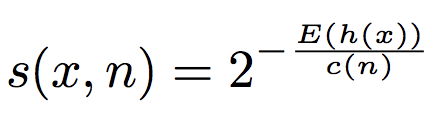

where h(x) is the path length of observation x, c(n) is the average path length of unsuccessful search in a Binary Search Tree. 
for a given n, c(n) is a constant value which is required to normalize h(x). 


Each observation is given an anomaly score and the following decision can be made on its basis:
A score close to 1 indicates anomalies
Score much smaller than 0.5 indicates normal observations
If all scores are close to 0.5 then the entire sample does not seem to have clearly distinct anomalies